In [ ]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os

# Define the zip path and extraction destination
zip_path = "/content/archive (1).zip"
extract_path = "/content/dataset"

# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Saving archive (1).zip to archive (1).zip


In [ ]:
import os
import zipfile
import gc
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 1️⃣ Unzip archive
zip_path = "/content/archive (1).zip"
extract_path = "/content/dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# 2️⃣ Load images & labels manually, resize smaller to save RAM
train_path = os.path.join(extract_path, "3_cls", "train")
images, labels = [], []
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir): continue
    for fn in os.listdir(class_dir):
        if fn.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(os.path.join(class_dir, fn)) \
                       .convert('RGB') \
                       .resize((128, 128))
            images.append(np.array(img))
            labels.append(class_name)

X = np.stack(images)                      # shape: (N,128,128,3)
le = LabelEncoder()
y = le.fit_transform(labels)              # integer labels

# 3️⃣ Split into train & test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 4️⃣ Preprocess for MobileNetV2
X_train = preprocess_input(X_train.astype("float32"))
X_test  = preprocess_input(X_test.astype("float32"))

# Free up original arrays
del X, images, labels
gc.collect()

# 5️⃣ Build MobileNetV2 + classifier head
base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(128, 128, 3)
)
base.trainable = False

x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation="relu")(x)
output = Dense(len(le.classes_), activation="softmax")(x)
model = Model(inputs=base.input, outputs=output)

model.compile(
    optimizer=Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# 6️⃣ Train & evaluate
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=16
)

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {acc * 100:.2f}%")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 76s 211ms/step - accuracy: 0.5989 - loss: 0.7451 - val_accuracy: 0.7014 - val_loss: 0.5867
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 87s 228ms/step - accuracy: 0.7231 - loss: 0.5516 - val_accuracy: 0.7245 - val_loss: 0.5510
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 73s 224ms/step - accuracy: 0.7399 - loss: 0.5207 - val_accuracy: 0.7122 - val_loss: 0.5409
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.7680 - loss: 0.4850 - val_accuracy: 0.7315 - val_loss: 0.5393
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.7803 - loss: 0.4604 - val_accuracy: 0.7523 - val_loss: 0.5171
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.8011 - loss: 0.4472 - val_accuracy: 0.7778 - val_loss: 0.4777
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 87s 240ms/step - accuracy: 0.8116 - loss: 0.4210 - val_accuracy: 0.7870 - val_loss: 0.4666
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━

81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 170ms/step

Classification Report:

              precision    recall  f1-score   support

          AD       0.83      0.70      0.76       513
     CONTROL       0.74      0.82      0.77       602
          PD       0.81      0.89      0.85       181

    accuracy                           0.78      1296
   macro avg       0.79      0.80      0.79      1296
weighted avg       0.78      0.78      0.78      1296



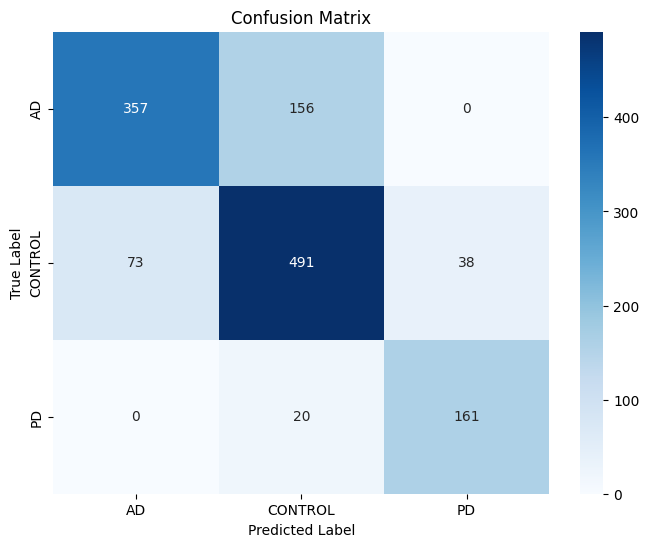

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Make predictions
y_pred = model.predict(X_test, batch_size=16)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# 2️⃣ Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# 3️⃣ Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# 4️⃣ Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
